In [7]:
import lalsimulation
import numpy as np

In [109]:
import lalsimulation, lal

def generate_new_points(mass1 = 10, q=1, spin1=[0,0,0], spin2=[0,0,0], npoints = 300, tstart = -0.1, tend = 0.005):
    
    
    mass1 = mass1 * lal.MSUN_SI
    mass2 = mass1 * q
    
    chi1_l = 0
    chi2_l = 0
    chip = 0
    thetaJ = 0
    m1 = mass1
    distance = 5 * lal.PC_SI
    alpha0 = 0
    phic = 0
    f_ref = 100 * lal.HertzUnit,
    waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
    approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
    #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
    #f, ax = plt.subplots(10, sharey=True, figsize=(5,15))
    
    coaphase = 0
    flower = 10 
    fref = 0.001
    distance = 400 *1e6 * lal.PC_SI
    z = 0.0
    inclination = 0.0
    lambda1 = lambda2 = 0.0
    amporder = 0
    phorder = 0
    dt = (tend-tstart)/npoints
    hp, hc = lalsimulation.SimInspiralTD(
                                         mass1, mass2,
                                         spin1[0], spin1[1], spin1[2],
                                         spin2[0], spin2[1], spin2[2],
                                         distance, inclination, 
                                         0, 0, 0, 0, dt, 40, float(fref), lal.CreateDict(),
                                         approximant
                                        )
    #-0.1,0.005
    times = np.linspace(0, len(hp.data.data)*hp.deltaT, len(hp.data.data)) + hp.epoch
    
    data = np.zeros((npoints, 9))
    
    data[:,-1] =  hp.data.data[(tstart<times) & (times<tend)]
    data[:,0] = times[(tstart<times) & (times<tend)] 
    data[:,1] = q * np.ones(npoints)
    data[:,2:5] = spin1 * np.ones((npoints, 3))
    data[:,5:8] = spin2 * np.ones((npoints, 3))
    return data

In [110]:
data = generate_new_points(q=3, tstart = -0.02)

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

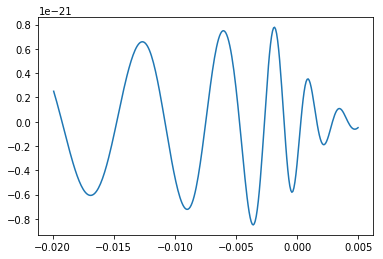

In [112]:
plt.plot(data[:,0], data[:,-1])

# Generate a catalogue with only $q$ changes

In [114]:
data = []
for q in np.linspace(1,10, 20):
    data.append( generate_new_points(q=q, tstart = -0.02) )

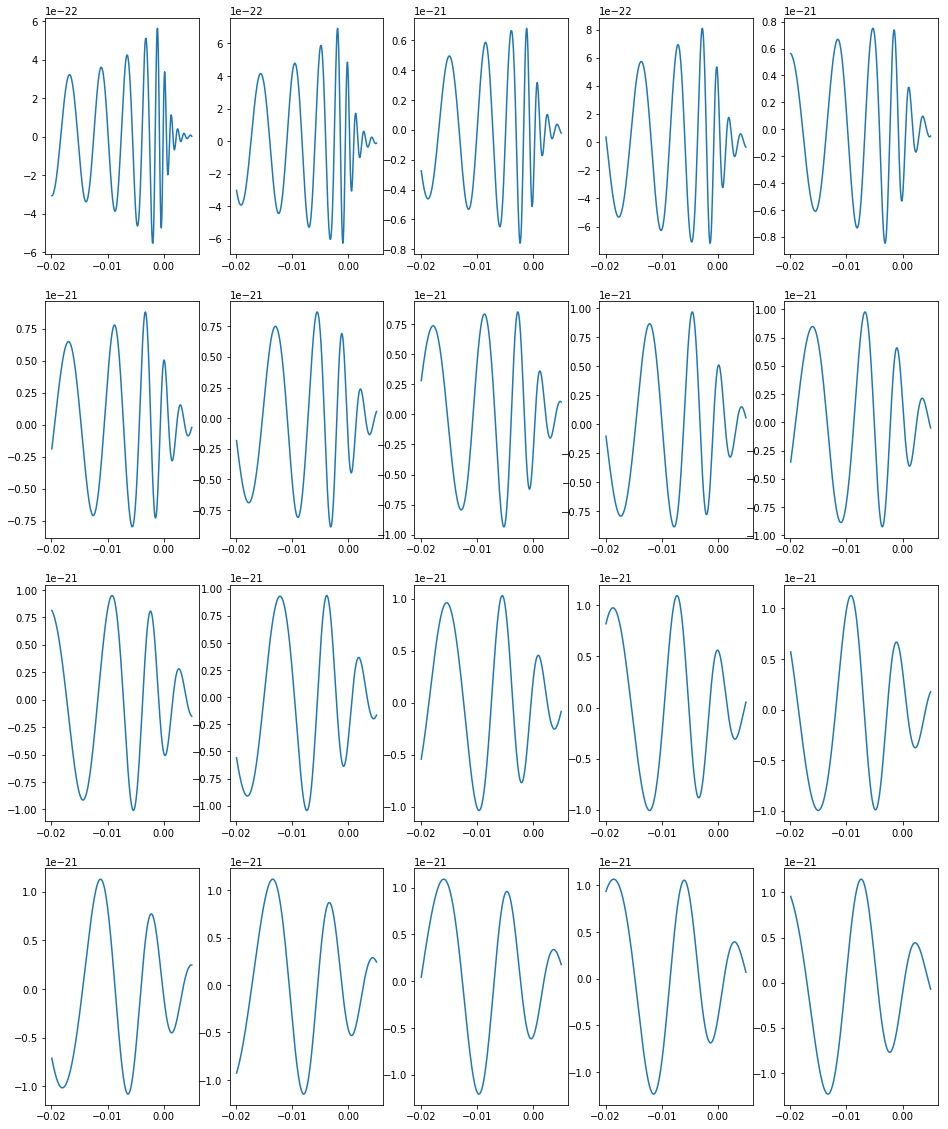

In [121]:
f, ax = plt.subplots(4,5, figsize=(16,20))
for i,dat in enumerate(data):
    ax[np.unravel_index(i, (4,5))].plot(dat[:,0], dat[:,-1])

Now produce a surrogate model over the catalogue.

In [144]:
import astropy
from astropy.table import Table
import os
from glob import glob
import numpy as np
import george
from george import kernels
import emcee
import corner

In [219]:
def normalise(array):
    array = array.copy()#.T
    #dc = array.min(axis=0)
    #array -= dc
    dc = 0
    
    scale = np.array(np.abs(array).max(axis=0), dtype=np.float32)
    array /= scale
    return array, dc, scale

In [220]:
training = np.vstack(data)

In [221]:
training_x = training[:,:2]
training_y = training[:,-1]

In [222]:
training_x, x_dc, x_scale = normalise(training_x)
#training_y, y_dc, y_scale = normalise(training_y)

In [225]:
rng = np.random.RandomState(0)
k0 =  np.std(training_y)**2
sep = np.array([0.01, 0.1,])# 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
sep = np.random.rand(len(sep))
k3 = kernels.Matern52Kernel(sep**2, ndim=len(sep))
kernel = k0 + k3
gp = george.GP(kernel, tol=1e-6, solver=george.HODLRSolver)
gp.compute(training_x, yerr=0.001)

In [226]:
MAP = minimize(neg_ln_like, gp.get_vector(), method="BFGS", )

array([ -9.85736067e+01,  -7.77552819e-02,  -1.24932920e+00])

In [233]:
from IPython.core.display import clear_output
def run_sampler(sampler, initial, iterations):
    """
    Run the MCMC sampler for some number of iterations, 
    but output a progress bar so you can keep track of what's going on
    """
    sampler.run_mcmc(initial, 1)
    for iteration in xrange(iterations/10-1):
        sampler.run_mcmc(None, 10)
        clear_output()
        print "{}% \r".format(1000*float(iteration+1) / iterations)
    return sampler

In [234]:
from scipy.optimize import minimize
def neg_ln_like(p):
    gp.set_vector(p)
    return -gp.lnlikelihood(training_y)

def ln_like(p):
    if np.any(p[2:]>15): return -np.inf
    if np.any(p[2:]<-15): return -np.inf
    #if p[0]<2: return -np.inf
    if p[0]<-20: return -np.inf
    #if -12>p[1]>-8: return -np.inf
    if -15>p[1]>15: return -np.inf
    gp.set_vector(p)
    return gp.lnlikelihood(training_y)

def grad_neg_ln_like(p):
    gp.set_vector(p)
    return gp.grad_lnlikelihood(training_y)

In [235]:
ndim, nwalkers = len(sep)+1, 100
p0 = [np.random.rand(len(sep)+1) for i in range(nwalkers)]
#p0 = [MAP.x for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, threads=4)
burn = run_sampler(sampler, p0, 1000)
#samples = sampler.run_mcmc(p0, 500)
#samples = sampler.chain[:, :, :].reshape((-1, ndim))

99.0% 


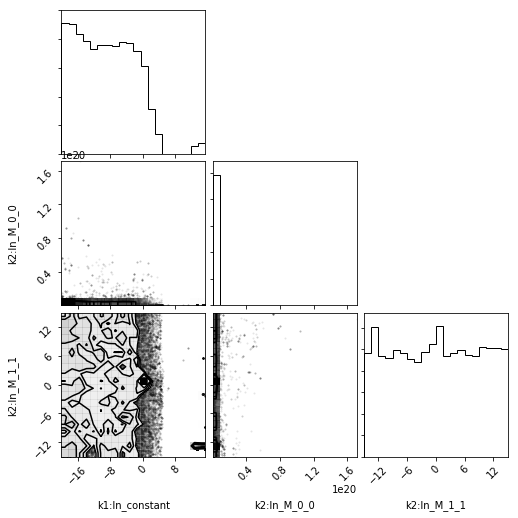

In [161]:
samples = burn.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=gp.kernel.get_parameter_names() ,lines=np.median(samples, axis=0))

In [227]:
def draw_waveform(parameters, start, end):
    """
    Draw a sample waveform from the Gaussian Process.
    """
    times = np.linspace(start, end, 200)
    rowdata = np.zeros((len(parameters), len(times)))
    
    for i, col in enumerate(parameters):
        if i == 0: 
            rowdata[i,:] = times
        else:
            rowdata[i,:] = np.tile(parameters[i], len(times))
    prediction = gp.predict(training_y, rowdata.T)
    return times, prediction

In [228]:
gp.set_vector(MAP.x)

True

In [229]:
parameters = training_x[2,:]

In [230]:
#gp.set_vector(hypers)
test_waveform = draw_waveform([0,1], -1, 1)

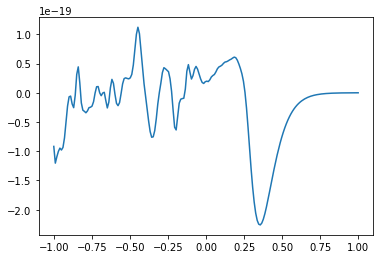

In [232]:
plt.plot(test_waveform[0], test_waveform[1][0])
#plt.plot(training_x_batch[0,:], training_y_batch)
#plt.fill_between(test_waveform[0], test_waveform[1][0] - np.diag(test_waveform[1][1]), test_waveform[1][0] + np.diag(test_waveform[1][1]), alpha=0.2)

In [180]:
parameters

array([-0.01975263,  1.        ])